In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import random

def set_seed(seed=123):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(123)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving actual_aug.csv to actual_aug.csv
Saving merged_energy_weather_data.csv to merged_energy_weather_data.csv
Saving weather_forecasts_aug.csv to weather_forecasts_aug.csv


In [ ]:
import pandas as pd

# Load datasets
historical_df = pd.read_csv("merged_energy_weather_data.csv", parse_dates=["Date"])
forecast_df = pd.read_csv("weather_forecasts_aug.csv", parse_dates=["Date"])
actual_df = pd.read_csv("actual_aug.csv", parse_dates=["Date"])

In [ ]:
historical_df.columns = [
    "date", "price", "temp", "precip", "wind", "humidity",
    "cloud", "radiation", "week_day", "month", "day_month"
]
print(historical_df.shape)
print(historical_df.head())

historical_df = historical_df.sort_values("date").reset_index(drop=True)
cloud_missing = historical_df['cloud'].isna()
historical_df.loc[cloud_missing, 'cloud'] = (
    historical_df['cloud'].shift(1) + historical_df['cloud'].shift(-1)
) / 2
print("Remaining NaNs:\n", historical_df.isna().sum())

(3865, 11)
        date      price      temp    precip       wind   humidity      cloud  \
0 2015-01-01  14.706087  6.440000  3.060714   8.392733  93.472826  95.130383   
1 2015-01-02   7.075217  6.490322  5.457143  12.129323  84.318486  70.348317   
2 2015-01-03  15.683333  4.429734  4.339286   8.461127  83.168743  35.944177   
3 2015-01-04  23.827727  3.844092  1.325000   6.188518  79.221513  30.214925   
4 2015-01-05  38.073750  4.910970  0.978571   3.414181  92.058873  77.380103   

    radiation  week_day  month  day_month  
0   83.391304         3      1          1  
1  456.913044         4      1          2  
2  503.043478         5      1          3  
3  705.652174         6      1          4  
4  239.478261         0      1          5  
Remaining NaNs:
 date         0
price        0
temp         0
precip       0
wind         0
humidity     0
cloud        0
radiation    0
week_day     0
month        0
day_month    0
dtype: int64


In [ ]:
df = historical_df.copy()
df = df.drop(columns=["day_month"])

df = df.sort_values("date").reset_index(drop=True)
for lag in range(1, 8):
    df[f"lag_{lag}"] = df["price"].shift(lag)
df = df.dropna().reset_index(drop=True)

df.head()

,date,price,temp,precip,wind,humidity,cloud,radiation,week_day,month,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
0,2015-01-08,24.343478,6.013413,3.214286,7.359274,92.091256,71.431795,288.086956,3,1,29.011667,29.161739,38.073750,23.827727,15.683333,7.075217,14.706087
1,2015-01-09,23.687917,5.783474,9.492857,10.275274,81.372204,72.396564,270.913044,4,1,24.343478,29.011667,29.161739,38.073750,23.827727,15.683333,7.075217
2,2015-01-10,14.021250,6.319171,7.303571,11.792501,83.443880,73.162782,236.913043,5,1,23.687917,24.343478,29.011667,29.161739,38.073750,23.827727,15.683333
3,2015-01-11,4.296087,3.989937,2.457143,10.834715,79.724570,42.435521,406.434783,6,1,14.021250,23.687917,24.343478,29.011667,29.161739,38.073750,23.827727
4,2015-01-12,10.938696,6.529484,2.867857,9.851411,87.450542,69.666470,123.043478,0,1,4.296087,14.021250,23.687917,24.343478,29.011667,29.161739,38.073750


In [ ]:
forecast_df.columns = [
    "date", "temp", "precip", "wind", "humidity",
    "cloud", "radiation", "week_day", "month"
]
print(forecast_df.shape)
forecast_df.head()

(14, 9)


,date,temp,precip,wind,humidity,cloud,radiation,week_day,month
0,2025-08-01,18.270965,5.845946,2.832688,85.943131,65.269895,5205.140541,4,8
1,2025-08-02,17.730649,4.883784,2.554017,88.593468,83.169670,3531.024324,5,8
2,2025-08-03,17.222579,14.102703,5.377834,90.596847,92.023086,2040.202703,6,8
3,2025-08-04,17.332620,10.635135,5.646145,86.659347,91.268206,3913.359459,0,8
4,2025-08-05,16.167042,2.964865,8.309287,77.295233,69.349474,4928.097297,1,8


In [ ]:
actual_df.columns = ["date", "price"]
print(actual_df.shape)
actual_df.head()

(14, 2)


,date,price
0,2025-08-01,93.229583
1,2025-08-02,65.464583
2,2025-08-03,42.023333
3,2025-08-04,41.297083
4,2025-08-05,-0.035417


Feedforward NN

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Feedforward NN Model
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim, hidden_dims=[64], dropout=0.0):
        super(FeedforwardNN, self).__init__()
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, 1))  # Output layer
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Define feature columns (input features for the model)
feature_cols = [
    "temp", "precip", "wind", "humidity", "cloud", "radiation",
    "week_day", "month",
    "lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6", "lag_7"
]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Extract input (X) and target (y) for training
X_train = df[feature_cols].values
y_train = df["price"].values.reshape(-1, 1)

# Fit scalers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)

# Convert to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).to(device)

# Initialize and train the model (best parameters)
model_ff = FeedforwardNN(input_dim=X_train.shape[1], hidden_dims=[64], dropout=0.0).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_ff.parameters(), lr=0.001)

# Simple training loop
epochs = 100
for epoch in range(epochs):
    model_ff.train()
    optimizer.zero_grad()
    outputs = model_ff(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f}")

Epoch 10/100 - Loss: 0.0167
Epoch 20/100 - Loss: 0.0089
Epoch 30/100 - Loss: 0.0083
Epoch 40/100 - Loss: 0.0057
Epoch 50/100 - Loss: 0.0050
Epoch 60/100 - Loss: 0.0039
Epoch 70/100 - Loss: 0.0032
Epoch 80/100 - Loss: 0.0026
Epoch 90/100 - Loss: 0.0022
Epoch 100/100 - Loss: 0.0020


In [ ]:
# Create a working copy of the forecast data
final_forecast_df = forecast_df.copy()
final_forecast_df = final_forecast_df.sort_values("date").reset_index(drop=True)

# Initialize lag window from final 7 days of training set
lag_window = df["price"].iloc[-7:].tolist()

# Add placeholder lag columns
for lag in range(1, 8):
    final_forecast_df[f"lag_{lag}"] = np.nan

# Fill lags for the first forecast row
for i in range(14):
    for lag_i in range(1, 8):
        final_forecast_df.loc[i, f"lag_{lag_i}"] = lag_window[-lag_i]

In [ ]:
model_ff.eval()
ffnn_preds = []

for i in range(14):
    row = final_forecast_df.iloc[i].copy()

    # Set lag values in row from current lag_window
    for lag_i in range(1, 8):
        row[f"lag_{lag_i}"] = lag_window[-lag_i]

    print(f"\nDay {i+1} – Current lag window:", lag_window[::-1])

    # Prepare input row
    input_row = row[feature_cols].values.reshape(1, -1)
    input_scaled = scaler_X.transform(input_row)
    input_tensor = torch.tensor(input_scaled, dtype=torch.float32).to(device)

    # Predict
    with torch.no_grad():
        pred_scaled = model_ff(input_tensor).cpu().numpy().flatten()
        pred_price = scaler_y.inverse_transform(pred_scaled.reshape(1, -1)).flatten()[0]

    print(f"Prediction: {pred_price:.2f}")

    # Append prediction
    ffnn_preds.append(pred_price)

    # Update lag window (autoregressively)
    lag_window.append(pred_price)
    lag_window = lag_window[1:]


Day 1 – Current lag window: [86.42, 72.21791667, 58.23708333, 68.97291667, 78.7925, 88.48833333, 95.43916667]
Prediction: 72.91

Day 2 – Current lag window: [np.float32(72.91407), 86.42, 72.21791667, 58.23708333, 68.97291667, 78.7925, 88.48833333]
Prediction: 69.78

Day 3 – Current lag window: [np.float32(69.77921), np.float32(72.91407), 86.42, 72.21791667, 58.23708333, 68.97291667, 78.7925]
Prediction: 48.46

Day 4 – Current lag window: [np.float32(48.463665), np.float32(69.77921), np.float32(72.91407), 86.42, 72.21791667, 58.23708333, 68.97291667]
Prediction: 89.47

Day 5 – Current lag window: [np.float32(89.467224), np.float32(48.463665), np.float32(69.77921), np.float32(72.91407), 86.42, 72.21791667, 58.23708333]
Prediction: 78.31

Day 6 – Current lag window: [np.float32(78.30679), np.float32(89.467224), np.float32(48.463665), np.float32(69.77921), np.float32(72.91407), 86.42, 72.21791667]
Prediction: 79.15

Day 7 – Current lag window: [np.float32(79.15092), np.float32(78.30679), 

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

actual_prices = actual_df["price"].values[:14]

def mape(actual, predicted, eps=5):
    """
    Compute a stable Mean Absolute Percentage Error (MAPE) by flooring small actual values.

    Parameters:
        actual (np.array): Actual target values
        predicted (np.array): Predicted values
        eps (float): Minimum denominator value to avoid exploding percentages

    Returns:
        float: MAPE percentage
    """
    denom = np.maximum(np.abs(actual), eps)
    return np.mean(np.abs(actual - predicted) / denom) * 100

def smape(actual, predicted, eps=1e-8):
    """
    Compute the Symmetric Mean Absolute Percentage Error (SMAPE).

    Parameters:
        actual (np.array): Actual values
        predicted (np.array): Predicted values
        eps (float): Small value to prevent division by zero

    Returns:
        float: SMAPE percentage
    """
    actual = np.array(actual)
    predicted = np.array(predicted)

    denominator = (np.abs(actual) + np.abs(predicted)) + eps
    smape_val = np.mean(2 * np.abs(predicted - actual) / denominator) * 100
    return smape_val

mae = mean_absolute_error(actual_prices, ffnn_preds)
mse = mean_squared_error(actual_prices, ffnn_preds)
rmse = np.sqrt(mse)

mape_value = mape(actual_prices, ffnn_preds)
smape_val = smape(actual_prices, ffnn_preds)

print("\n Feedforward NN – Pseudo-Test Evaluation:")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape_value:.4f}")
print(f"SMAPE: {smape_val:.4f}")


 Feedforward NN – Pseudo-Test Evaluation:
MAE:  25.1462
RMSE: 32.7650
MAPE: 150.8063
SMAPE: 42.0494


In [ ]:
print(actual_prices)

[ 9.32295833e+01  6.54645833e+01  4.20233333e+01  4.12970833e+01
 -3.54166670e-02  2.92762500e+01  6.96300000e+01  8.34918182e+01
  5.88895833e+01  5.11141667e+01  8.41520833e+01  8.51462500e+01
  1.00014583e+02  1.05340417e+02]


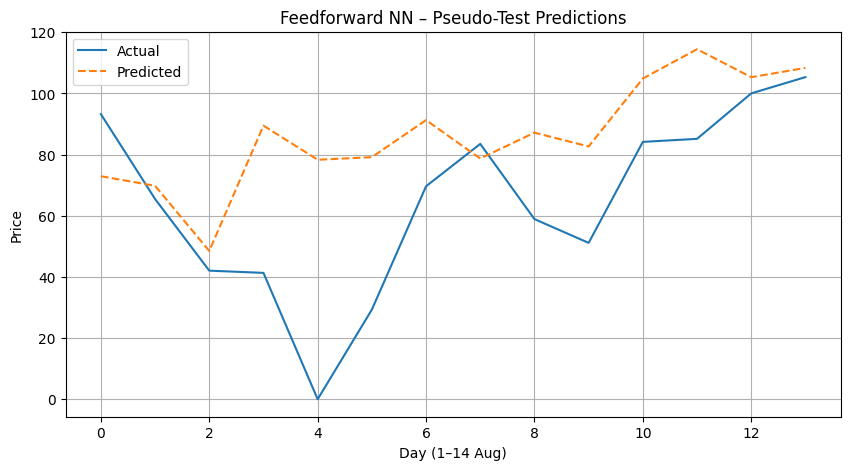

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(actual_prices, label="Actual")
plt.plot(ffnn_preds, label="Predicted", linestyle='--')
plt.title("Feedforward NN – Pseudo-Test Predictions")
plt.xlabel("Day (1–14 Aug)")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
for i, (true, pred) in enumerate(zip(actual_prices, ffnn_preds)):
    print(f"Day {i+1}: Actual={true:.2f}, Predicted={pred:.2f}")

Day 1: Actual=93.23, Predicted=72.91
Day 2: Actual=65.46, Predicted=69.78
Day 3: Actual=42.02, Predicted=48.46
Day 4: Actual=41.30, Predicted=89.47
Day 5: Actual=-0.04, Predicted=78.31
Day 6: Actual=29.28, Predicted=79.15
Day 7: Actual=69.63, Predicted=91.27
Day 8: Actual=83.49, Predicted=78.71
Day 9: Actual=58.89, Predicted=87.17
Day 10: Actual=51.11, Predicted=82.64
Day 11: Actual=84.15, Predicted=104.88
Day 12: Actual=85.15, Predicted=114.46
Day 13: Actual=100.01, Predicted=105.31
Day 14: Actual=105.34, Predicted=108.35


TCN

In [ ]:
import torch
import torch.nn as nn

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size]  # crop from the end only

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(
            self.conv1, self.chomp1, self.relu1, self.dropout1,
            self.conv2, self.chomp2, self.relu2, self.dropout2
        )

        self.downsample = nn.Conv1d(in_channels, out_channels, 1) \
            if in_channels != out_channels else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self, num_inputs, output_size, num_channels, kernel_size=2, dropout=0.2):
        super().__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            in_ch = num_inputs if i == 0 else num_channels[i-1]
            out_ch = num_channels[i]
            dilation_size = 2 ** i
            padding = (kernel_size - 1) * dilation_size
            layers += [TemporalBlock(in_ch, out_ch, kernel_size, stride=1, dilation=dilation_size,
                                     padding=padding, dropout=dropout)]

        self.network = nn.Sequential(*layers)
        self.linear = nn.Linear(num_channels[-1], output_size)

    def forward(self, x):
        # x: [batch, seq_len, features] -> [batch, features, seq_len]
        x = x.permute(0, 2, 1)
        y = self.network(x)
        # Take the last time step's output
        y = y[:, :, -1]
        return self.linear(y)

In [ ]:
# Best hyperparameters
channels = [128, 128]
kernel_size = 5
dropout = 0.2
lr = 0.001
batch_size = 32
sequence_len = 30
horizon = 14

# Input/output sizes
input_size = df.drop(columns=["price", "date"]).shape[1]
output_size = 1

# Reinitialize model with the updated TCN definition
model_tcn = TCN(num_inputs=input_size, output_size=output_size, num_channels=channels,
                kernel_size=kernel_size, dropout=dropout).to(device)

# Re-train the model on full data
X_full = df.drop(columns=["price", "date"]).values
y_full = df["price"].values.reshape(-1, 1)

from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X_full)
y_scaled = scaler_y.fit_transform(y_full)

# Create input sequences for training
def create_tcn_sequences(X, y, sequence_len):
    X_seq, y_seq = [], []
    for i in range(len(X) - sequence_len):
        X_seq.append(X[i:i+sequence_len])
        y_seq.append(y[i+sequence_len])
    return torch.tensor(X_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32)

X_train_tcn, y_train_tcn = create_tcn_sequences(X_scaled, y_scaled, sequence_len)

train_dataset = torch.utils.data.TensorDataset(X_train_tcn, y_train_tcn)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Optimizer and loss
optimizer = torch.optim.Adam(model_tcn.parameters(), lr=lr)
criterion = nn.MSELoss()

# Train for fixed epochs
model_tcn.train()
for epoch in range(50):
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model_tcn(xb).squeeze()
        loss = criterion(preds, yb.squeeze())
        loss.backward()
        optimizer.step()

In [ ]:
# Starting inputs
last_rows = df.drop(columns=["price", "date"]).iloc[-sequence_len:].copy()
lag_window = df["price"].iloc[-7:].tolist()

tcn_preds = []

for i in range(14):  # Day 1 to 14 August
    row = forecast_df.iloc[i].copy()

    # Insert lag values into the row
    for lag_i in range(1, 8):
        row[f"lag_{lag_i}"] = lag_window[-lag_i]

    # Combine with previous sequence
    input_seq = pd.concat([last_rows.iloc[1:], row.to_frame().T], ignore_index=True)
    last_rows = input_seq.copy()

    # Scale and predict
    X_input = scaler_X.transform(input_seq.drop(columns=["date"]).values).reshape(1, sequence_len, -1)
    X_tensor = torch.tensor(X_input, dtype=torch.float32).to(device)

    with torch.no_grad():
        pred_scaled = model_tcn(X_tensor).cpu().numpy().flatten()[0]
        pred_price = scaler_y.inverse_transform([[pred_scaled]])[0, 0]

    tcn_preds.append(pred_price)
    lag_window.append(pred_price)
    lag_window = lag_window[1:]


📊 TCN – Pseudo-Test Evaluation:
MAE:   27.5813
RMSE:  33.0569
MAPE:  128.2787
SMAPE: 46.4436


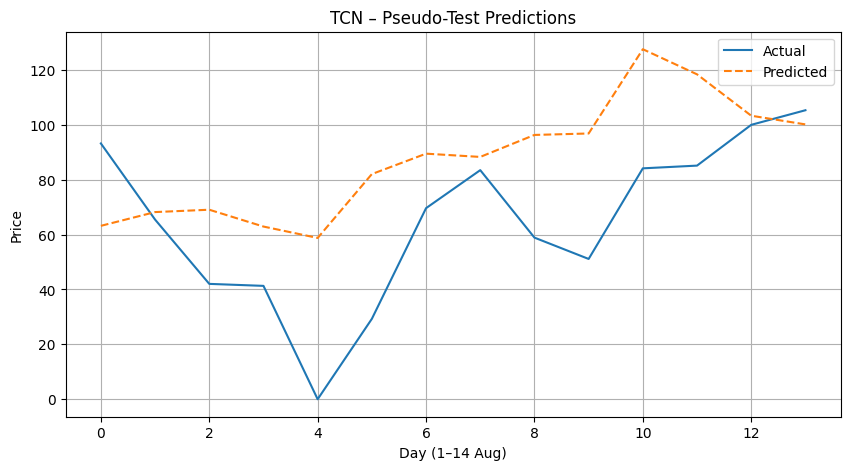

In [ ]:
actual_prices = actual_df["price"].values[:14]

def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    return np.mean(np.abs(y_true - y_pred) / np.maximum(denom, 5)) * 100

def mape_stable(y_true, y_pred, eps=5):
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs(y_true - y_pred) / denom) * 100

from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(actual_prices, tcn_preds)
rmse = np.sqrt(mean_squared_error(actual_prices, tcn_preds))
mape = mape_stable(actual_prices, tcn_preds)
smape_val = smape(actual_prices, tcn_preds)

print("\n TCN – Pseudo-Test Evaluation:")
print(f"MAE:   {mae:.4f}")
print(f"RMSE:  {rmse:.4f}")
print(f"MAPE:  {mape:.4f}")
print(f"SMAPE: {smape_val:.4f}")

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(actual_prices, label="Actual")
plt.plot(tcn_preds, label="Predicted", linestyle='--')
plt.title("TCN – Pseudo-Test Predictions")
plt.xlabel("Day (1–14 Aug)")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

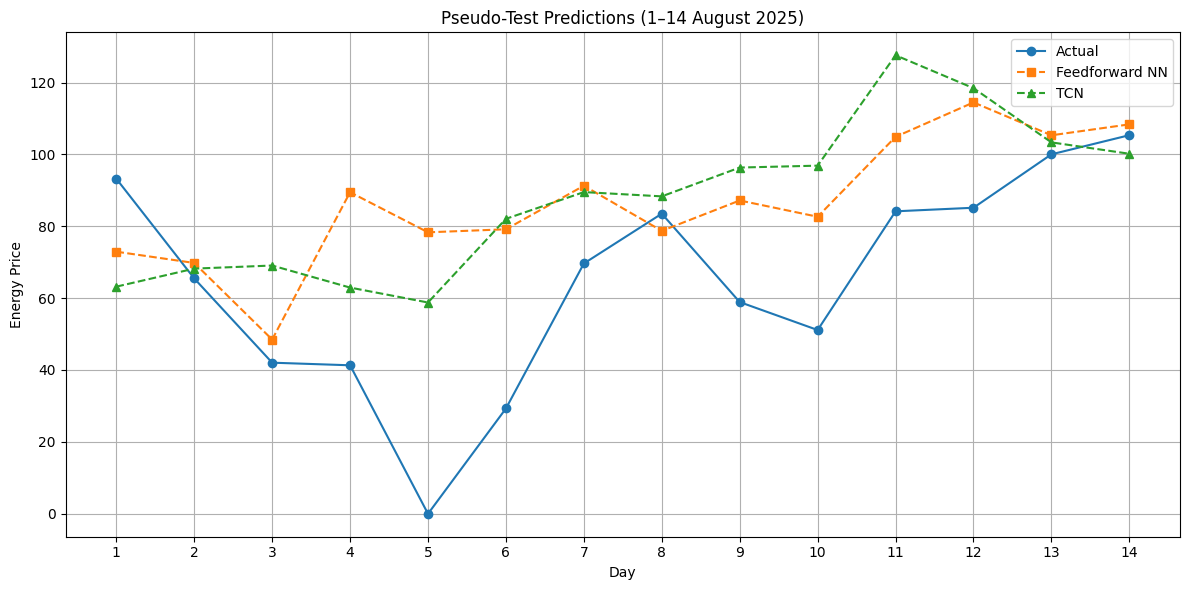

In [ ]:
# Plot of actual prices vs. FFNN predictions vs. TCN predictions
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label="Actual", marker='o')
plt.plot(ffnn_preds, label="Feedforward NN", linestyle='--', marker='s')
plt.plot(tcn_preds, label="TCN", linestyle='--', marker='^')

plt.title("Pseudo-Test Predictions (1–14 August 2025)")
plt.xlabel("Day")
plt.ylabel("Energy Price")
plt.xticks(ticks=np.arange(14), labels=np.arange(1, 15))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()